In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
data = pd.read_csv("loan_prediction_dataset.csv")

In [ ]:
data.head()

,age,income,credit_score,dependents,home_owner,loan_approved
0,54,100000.00,334,0,1,1
1,67,85233.42,593,2,1,1
2,29,16737.15,502,0,0,1
3,42,69332.50,367,3,0,0
4,58,28211.14,430,0,1,1


In [ ]:
data.duplicated().sum()

0

In [ ]:
data.isnull().sum()

,0
age,0
income,0
credit_score,0
dependents,0
home_owner,0
loan_approved,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1000 non-null   int64  
 1   income         1000 non-null   float64
 2   credit_score   1000 non-null   int64  
 3   dependents     1000 non-null   int64  
 4   home_owner     1000 non-null   int64  
 5   loan_approved  1000 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 47.0 KB


In [ ]:
data.describe()

,age,income,credit_score,dependents,home_owner,loan_approved
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,44.54400,31943.240590,573.644000,2.027000,0.494000,0.782000
std,13.95345,28058.315386,163.781078,1.422074,0.500214,0.413094
min,20.00000,4000.000000,300.000000,0.000000,0.000000,0.000000
25%,33.00000,11057.325000,423.500000,1.000000,0.000000,1.000000
50%,44.00000,21712.035000,572.000000,2.000000,0.000000,1.000000
75%,57.00000,42369.575000,720.000000,3.000000,1.000000,1.000000
max,69.00000,100000.000000,849.000000,4.000000,1.000000,1.000000


<Axes: >

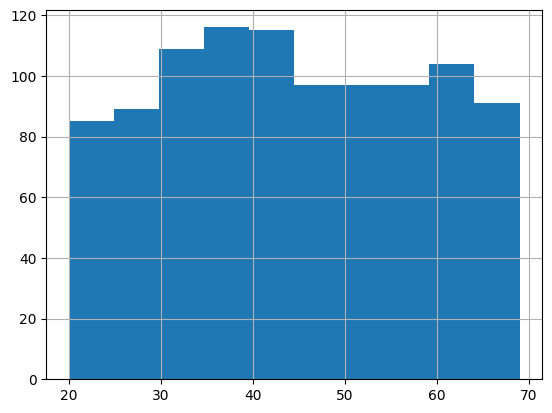

In [ ]:
data["age"].hist()

<Axes: >

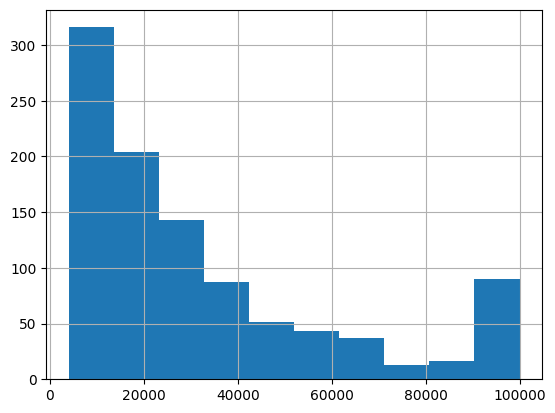

In [ ]:
data["income"].hist()

<Axes: >

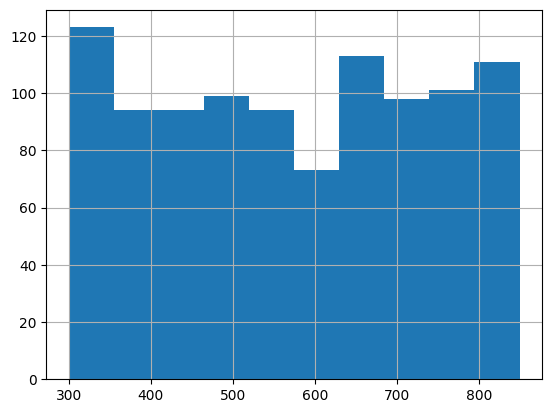

In [ ]:
data["credit_score"].hist()

In [ ]:
data["loan_approved"].value_counts()

,count
loan_approved,
1,782
0,218


In [ ]:
owner = data.loc[data.home_owner == 1]["loan_approved"]
rate_owner = sum(owner)/len(owner)

print("% of owner who had loan_approved:", rate_owner)

% of owner who had loan_approved: 0.8421052631578947


In [ ]:
notowner = data.loc[data.home_owner == 0]["loan_approved"]
rate_notowner = sum(notowner)/len(notowner)

print("% of not-owner who had loan_approved:", rate_notowner)

% of not-owner who had loan_approved: 0.7233201581027668


In [ ]:
data.shape

(1000, 6)

In [ ]:
# shuffle data
data = data.sample(frac=1)
data = data.reset_index(drop=True)  # reset index after shuffling

In [ ]:
X = data.drop('loan_approved', axis=1) 
Y = data['loan_approved']

In [ ]:
X.shape, Y.shape

((1000, 5), (1000,))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
!pip install bayesian-optimization

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
import joblib
import time
import os

class MetaLearnerPredictor:
    def __init__(self, model_dir='saved_model'):
        """
        Load the saved model, scaler, and mappings
        """
        self.model = tf.keras.models.load_model(os.path.join(model_dir, 'meta_learner_model.keras'))
        self.feature_scaler = joblib.load(os.path.join(model_dir, 'feature_scaler.pkl'))

        # Load the mappings
        mappings = joblib.load(os.path.join(model_dir, 'feature_mappings.pkl'))
        self.max_features_mapping = mappings['max_features_mapping']
        self.inverse_max_features_mapping = mappings['inverse_max_features_mapping']

    def predict_accuracy(self, dataset_features, hyperparams):
        """
        Predict accuracy for given dataset features and hyperparameters
        """
        # Scale dataset features
        dataset_scaled = self.feature_scaler.transform(dataset_features)

        # Convert max_features to numerical value
        if isinstance(hyperparams['max_features'], str):
            max_features_encoded = self.max_features_mapping.get(hyperparams['max_features'], 1)  # default to 'sqrt'
        else:
            max_features_encoded = hyperparams['max_features']

        # Combine features
        X = np.hstack([
            dataset_scaled,
            np.array([[
                hyperparams['n_estimators'],
                hyperparams['max_depth'],
                max_features_encoded,
                hyperparams['min_samples_split']
            ]])
        ])

        return self.model.predict(X)[0][0]

def find_best_hyperparameters(meta_learner, dataset_features, param_grid):
    """
    Find best hyperparameters using meta-learner
    """
    start_time = time.time()
    best_accuracy = 0
    best_params = None

    # Try all combinations from param_grid
    for n_est in param_grid['n_estimators']:
        for depth in param_grid['max_depth']:
            for feat in param_grid['max_features']:
                for min_split in param_grid['min_samples_split']:
                    params = {
                        'n_estimators': n_est,
                        'max_depth': depth,
                        'max_features': feat,
                        'min_samples_split': min_split
                    }

                    pred_accuracy = meta_learner.predict_accuracy(dataset_features, params)

                    if pred_accuracy > best_accuracy:
                        best_accuracy = pred_accuracy
                        best_params = params

    # Convert max_features back to string if it's in the mapping
    if isinstance(best_params['max_features'], (int, float)):
        if best_params['max_features'] in meta_learner.inverse_max_features_mapping:
            best_params['max_features'] = meta_learner.inverse_max_features_mapping[round(best_params['max_features'])]

    time_taken = time.time() - start_time

    return best_params, best_accuracy, time_taken

def compare_methods(dataset_features, param_grid, X_train, y_train):
    """
    Compare meta-learner with traditional methods
    Returns time taken and best parameters for each method
    """
    results = {}

    # 1. Grid Search
    start_time = time.time()
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=3,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    grid_time = time.time() - start_time

    results['grid_search'] = {
        'time': grid_time,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

    # 2. Bayesian Optimization
    def bo_objective(n_estimators, max_depth, min_samples_split):
        clf = RandomForestClassifier(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            max_features='sqrt',  # Fixed to 'sqrt' for simplicity
            min_samples_split=int(min_samples_split),
            random_state=42
        )
        clf.fit(X_train, y_train)
        return clf.score(X_train, y_train)

    start_time = time.time()
    pbounds = {
        'n_estimators': (param_grid['n_estimators'][0], param_grid['n_estimators'][-1]),
        'max_depth': (param_grid['max_depth'][0], param_grid['max_depth'][-1]),
        'min_samples_split': (param_grid['min_samples_split'][0], param_grid['min_samples_split'][-1])
    }

    bo = BayesianOptimization(
        f=bo_objective,
        pbounds=pbounds,
        random_state=42
    )

    bo.maximize(init_points=5, n_iter=10)
    bo_time = time.time() - start_time

    results['bayesian_opt'] = {
        'time': bo_time,
        'best_params': {
            'n_estimators': int(bo.max['params']['n_estimators']),
            'max_depth': int(bo.max['params']['max_depth']),
            'max_features': 'sqrt',
            'min_samples_split': int(bo.max['params']['min_samples_split'])
        },
        'best_score': bo.max['target']
    }

    # 3. Meta-Learner
    meta_learner = MetaLearnerPredictor()
    best_params, best_accuracy, meta_time = find_best_hyperparameters(
        meta_learner, dataset_features, param_grid
    )

    results['meta_learner'] = {
        'time': meta_time,
        'best_params': best_params,
        'best_score': best_accuracy
    }

    return results

In [ ]:

# X_train = pd.read_csv('')  
X = data.drop('loan_approved', axis=1) 
Y = data['loan_approved']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# User input for dataset characteristics
num_features = X_train.shape[1]  # Total number of features
num_samples = X_train.shape[0]   # Number of samples

# User inputs 
class_imbalance_ratio = 3.5872
num_classes = 2
num_categorical_features = 1
num_numerical_features = 4

# Create dataset features array
dataset_features = np.array([[
    num_features,
    num_samples,
    class_imbalance_ratio,
    num_classes,
    num_categorical_features,
    num_numerical_features
]])

# Define parameter grid
param_grid = {
    'n_estimators': [25, 50, 75, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']        # Adjust weights to handle the slight imbalance.
}

# Compare methods
results = compare_methods(dataset_features, param_grid, X_train, Y_train)

# Print results
for method, result in results.items():
    print(f"\n{method}:")
    print(f"Time taken: {result['time']:.2f} seconds")
    print("Best parameters:", result['best_params'])
    print(f"Best score: {result['best_score']:.4f}")

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.9337    | 5.622     | 9.606     | 116.5     |
| 2         | 0.9775    | 7.191     | 3.248     | 44.5      |
| 3         | 0.885     | 3.407     | 8.929     | 100.1     |
| 4         | 0.9838    | 7.957     | 2.165     | 146.2     |
| 5         | 0.9875    | 8.827     | 3.699     | 47.73     |
| 6         | 0.8875    | 3.162     | 9.779     | 62.28     |
| 7         | 0.8838    | 3.308     | 9.744     | 139.8     |
| 8         | 0.9637    | 9.742     | 9.551     | 44.62     |
| 9         | 0.8862    | 3.266     | 2.477     | 49.92     |
| 10        | 0.9838    | 9.902     | 5.474     | 44.88     |
| 11        | 0.88      | 3.493     | 2.051     | 149.7     |
| 12        | 1.0       | 9.823     | 2.299     | 142.4     |
| 13        | 0.9825    | 9.944     | 6.077     | 144.0     |
| 14        | 0.9975    | 9.912     | 2.212     | 36.61     |
| 15    

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def validate_rf_params(X_train, Y_train, params, name=""):
    """
    Train a Random Forest with given parameters and return the accuracy
    """
    # Create and train the model
    rf = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        max_features=params['max_features'],
        min_samples_split=params['min_samples_split'],
        random_state=42  # for reproducibility
    )

    # Fit and predict
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_train)

    # Calculate accuracy
    acc = accuracy_score(Y_train, y_pred)

    print(f"\n{name} Parameters:")
    print(f"Parameters used: {params}")
    print(f"Actual Training Accuracy: {acc:.4f}")

    return acc

# Parameters from the output
grid_search_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_split': 10
}

bayesian_opt_params = {
    'n_estimators': 142,
    'max_depth': 9,
    'max_features': 'sqrt',
    'min_samples_split': 2
}

meta_learner_params = {
    'n_estimators': 150,
    'max_depth': 10,
    'max_features': 'log2',
    'min_samples_split': 10
}

# Validate all three parameter combinations
grid_acc = validate_rf_params(X_train, Y_train, grid_search_params, "Grid Search")
bayesian_acc = validate_rf_params(X_train, Y_train, bayesian_opt_params, "Bayesian Optimization")
meta_acc = validate_rf_params(X_train, Y_train, meta_learner_params, "Meta-learner")


Grid Search Parameters:
Parameters used: {'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10}
Actual Training Accuracy: 0.9613

Bayesian Optimization Parameters:
Parameters used: {'n_estimators': 142, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 2}
Actual Training Accuracy: 1.0000

Meta-learner Parameters:
Parameters used: {'n_estimators': 150, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10}
Actual Training Accuracy: 0.9688
